In [1]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats
import cx_Oracle
from config import oracle_wfm_key
from config import oracle_ods_key
from sqlalchemy.types import String
from tqdm import tqdm
import datetime
from datetime import datetime
import datetime as dt
import time
import databases as db

In [2]:
# Get the current date
current_date = datetime.today()
# Set service level goal
service_level_goal = 0.65
# load the dataset
ods = db.oracle('cco_wfm',oracle_wfm_key)
query = f'''SELECT * FROM "CCO_WFM"."Staffing_Analysis_Regressors"'''
df = pd.read_sql(query, ods)

In [3]:
df['workgroup_set'].unique()

array(['Repair_ABS', 'Other', 'Financial_Services_Business',
       'Financial_Services_Residential', 'Repair_Cable_Business',
       'Repair_Cable_Residential', 'Repair_RPC', 'Cable_Consumer_Sales',
       'Cable_Consumer_Specialist', 'FST_Dispatch', 'Commercial_Billing',
       'Wireline_Consumer_Specialist', 'Repair_Wireline_Residential',
       'Wireline_Consumer_Sales', 'Cable_Seniors_CCO_Support',
       'Repair_Support-Chat', 'Repair_Continuum', 'Continuum_Sales',
       'Repair_Wireline_Business', 'APC', 'Wireline_Seniors_CCO_Support',
       'COAST', 'TDS_Corporate', 'Repair_Seniors'], dtype=object)

In [4]:
sales_df = df.loc[((df['workgroup_set'] == 'Cable_Consumer_Sales') | (df['workgroup_set'] == 'Wireline_Consumer_Sales')) & (df['call_date'] < pd.Timestamp(current_date.year, current_date.month, 1)) ]

In [5]:
# Group the sum of offered_calls by call_date
offered_calls = sales_df.groupby('call_date')['offered_calls'].sum().reset_index()

In [6]:
# Group the sum of inbound_handle by call_date
avg_handle_time = sales_df.groupby('call_date')['inbound_handle'].sum().reset_index()

# Calculate average handle time by dividing grouped offered_calls by the sum of inbound_handle
avg_handle_time['avg_handle_time'] = avg_handle_time['inbound_handle'] / sales_df.groupby('call_date')['offered_calls'].sum().values

# Drop extra columns
avg_handle_time.drop(columns=['inbound_handle'], inplace=True)

In [7]:
# Group offered_calls and in_sl by call_date
service_level_percent = sales_df.groupby('call_date').agg({'offered_calls': 'sum', 'in_sl': 'sum'}).reset_index()

# Calculate service_level_percent by dividing in_sl by offered_calls
service_level_percent['service_level_percent'] = service_level_percent['in_sl'] / service_level_percent['offered_calls']

# Drop extra columns
service_level_percent.drop(columns=['offered_calls', 'in_sl'], inplace=True)

In [8]:
# Group offered_calls and in_sl by call_date
service_level_percent_to_goal = sales_df.groupby('call_date').agg({'offered_calls': 'sum', 'in_sl': 'sum'}).reset_index()

# Calculate service_level_percent by dividing in_sl by offered_calls
service_level_percent_to_goal['service_level_percent'] = service_level_percent_to_goal['in_sl'] / service_level_percent_to_goal['offered_calls']

# Calculate service_level_percent by dividing in_sl by offered_calls
service_level_percent_to_goal['service_level_percent_to_goal'] = service_level_percent_to_goal['service_level_percent'] / service_level_goal

# Drop extra columns
service_level_percent_to_goal.drop(columns=['offered_calls', 'in_sl','service_level_percent'], inplace=True)

In [9]:
# Group the sum of offered_calls and abandoned_calls by call_date
abandon_percent = sales_df.groupby('call_date').agg({'offered_calls': 'sum', 'abandoned_calls': 'sum'}).reset_index()

# Calculate abandon_percent by dividing abandoned_calls by offered_calls
abandon_percent['abandon_percent'] = abandon_percent['abandoned_calls'] / abandon_percent['offered_calls']

# Drop extra columns
abandon_percent.drop(columns=['offered_calls', 'abandoned_calls'], inplace=True)

In [10]:
# Group the sum of offered_calls and queuetime by call_date
avg_speed_of_answer = sales_df.groupby('call_date').agg({'offered_calls': 'sum', 'queuetime': 'sum'}).reset_index()

# Calculate avg_speed_of_answer by dividing queuetime by offered_calls
avg_speed_of_answer['avg_speed_of_answer'] = avg_speed_of_answer['queuetime'] / avg_speed_of_answer['offered_calls']

# Drop extra columns
avg_speed_of_answer.drop(columns=['offered_calls', 'queuetime'], inplace=True)

In [11]:
# Group the maximum of occupancy by call_date
occupancy = sales_df.groupby('call_date')['occupancy'].max().reset_index()

In [12]:
# Group the maximum of attrition by workgroup_set and call_date
grouped_df = sales_df.groupby(['workgroup_set', 'call_date'])['attrition'].max().reset_index()

# Sum the totals by call_date
attrition = grouped_df.groupby('call_date')['attrition'].sum().reset_index()

In [13]:
seniors = df.loc[((df['workgroup_set'] == 'Cable_Seniors_CCO_Support') | (df['workgroup_set'] == 'Wireline_Seniors_CCO_Support')) & (df['call_date'] < pd.Timestamp(current_date.year, current_date.month, 1)) ]
# Group the sum of offered_calls by call_date
senior_calls = seniors.groupby('call_date')['offered_calls'].sum().reset_index()
senior_calls.columns = ['call_date','senior_calls']

In [14]:
call_date = offered_calls['call_date']
offered_calls = offered_calls['offered_calls']
avg_handle_time = avg_handle_time['avg_handle_time']
service_level_percent = service_level_percent['service_level_percent']
abandon_percent = abandon_percent['abandon_percent']
avg_speed_of_answer = avg_speed_of_answer['avg_speed_of_answer']
occupancy = occupancy['occupancy']
attrition = attrition['attrition']
senior_calls = senior_calls['senior_calls']
service_level_percent_to_goal = service_level_percent_to_goal['service_level_percent_to_goal']

In [15]:
# Concatenate the independent variables to create the feature matrix
df = pd.concat([call_date,offered_calls, avg_handle_time, service_level_percent, abandon_percent,
                            avg_speed_of_answer, occupancy, attrition, senior_calls,service_level_percent_to_goal], axis=1)

# Print the resulting feature matrix
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   call_date                      24 non-null     datetime64[ns]
 1   offered_calls                  24 non-null     int64         
 2   avg_handle_time                24 non-null     float64       
 3   service_level_percent          24 non-null     float64       
 4   abandon_percent                24 non-null     float64       
 5   avg_speed_of_answer            24 non-null     float64       
 6   occupancy                      24 non-null     float64       
 7   attrition                      24 non-null     float64       
 8   senior_calls                   24 non-null     int64         
 9   service_level_percent_to_goal  24 non-null     float64       
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 2.0 KB
None


In [16]:
# Get unique months from 'call_date' column
unique_months = pd.to_datetime(df['call_date']).dt.to_period('M').unique()

# Calculate business days per month (including Saturdays)
business_days_per_month = []
for month in unique_months:
    start_date = month.to_timestamp()
    end_date = (month.to_timestamp() + pd.offsets.MonthEnd()).normalize()
    business_days = pd.bdate_range(start=start_date, end=end_date, freq='B').shape[0]
    business_days_per_month.append(business_days)

# Create a DataFrame with the results
business_days_df = pd.DataFrame({'call_date': unique_months, 'business_days': business_days_per_month})

In [17]:
# Read the DataFrame with monthly values
staffing = df
staffing['call_date'] = pd.to_datetime(staffing['call_date']).dt.to_period('M')
staffing = staffing.merge(business_days_df, on='call_date', how='left')


# Convert 'offered_calls' column to float
staffing['offered_calls'] = staffing['offered_calls'].astype(float)

# Calculate the Total Monthly Call Minutes
staffing['total_call_minutes'] = staffing['offered_calls'] * staffing['avg_handle_time']

# Calcualte the Staffing Requirements
shrinkage = 0.30
occupancy = staffing['occupancy'].mean()
working_hours_per_day = 7.1667
staffing['staffing_requirements'] = ((((staffing['total_call_minutes']) / 3600) / occupancy) * (1 + shrinkage)) / (staffing['business_days'] * working_hours_per_day)

In [18]:
staffing_requirements = staffing[['call_date','staffing_requirements']]
df = df.merge(staffing_requirements, on='call_date', how='inner')
# Convert 'call_date' to datetime format
df['call_date'] = df['call_date'].dt.to_timestamp()

# Extract the month and year from the 'call_date' column
df['month'] = df['call_date'].dt.month
df['year'] = df['call_date'].dt.year
# Drop the original 'call_date' column
df = df.drop(columns=['call_date'])

In [19]:
df

,offered_calls,avg_handle_time,service_level_percent,abandon_percent,avg_speed_of_answer,occupancy,attrition,senior_calls,service_level_percent_to_goal,staffing_requirements,month,year
0,69384,488.092284,0.634267,0.101911,203.887755,0.550151,8.0,20691,0.975796,126.716744,7,2021
1,71048,484.562352,0.705270,0.062099,125.140792,0.553214,7.0,21792,1.085030,128.817319,8,2021
2,67314,487.727768,0.674570,0.071382,141.980658,0.538106,11.0,22714,1.037800,122.844470,9,2021
3,65971,477.905155,0.554926,0.109230,221.242379,0.554362,4.0,22354,0.853732,123.586461,10,2021
4,62176,505.464279,0.726197,0.045001,95.366428,0.514637,8.0,21425,1.117226,117.594220,11,2021
5,58125,488.980645,0.837763,0.028611,63.504310,0.498815,4.0,18961,1.288867,101.723714,12,2021
6,60285,510.968964,0.678909,0.069603,149.940931,0.785003,15.0,18781,1.044475,120.747988,1,2022
7,53495,474.382185,0.776185,0.057258,118.236209,0.519964,10.0,17114,1.194130,104.449647,2,2022
8,65589,499.121789,0.631127,0.085060,177.822211,0.568055,12.0,19733,0.970965,117.166947,3,2022
9,65924,468.218160,0.508844,0.163385,351.170712,0.598281,6.0,18438,0.782836,120.995138,4,2022


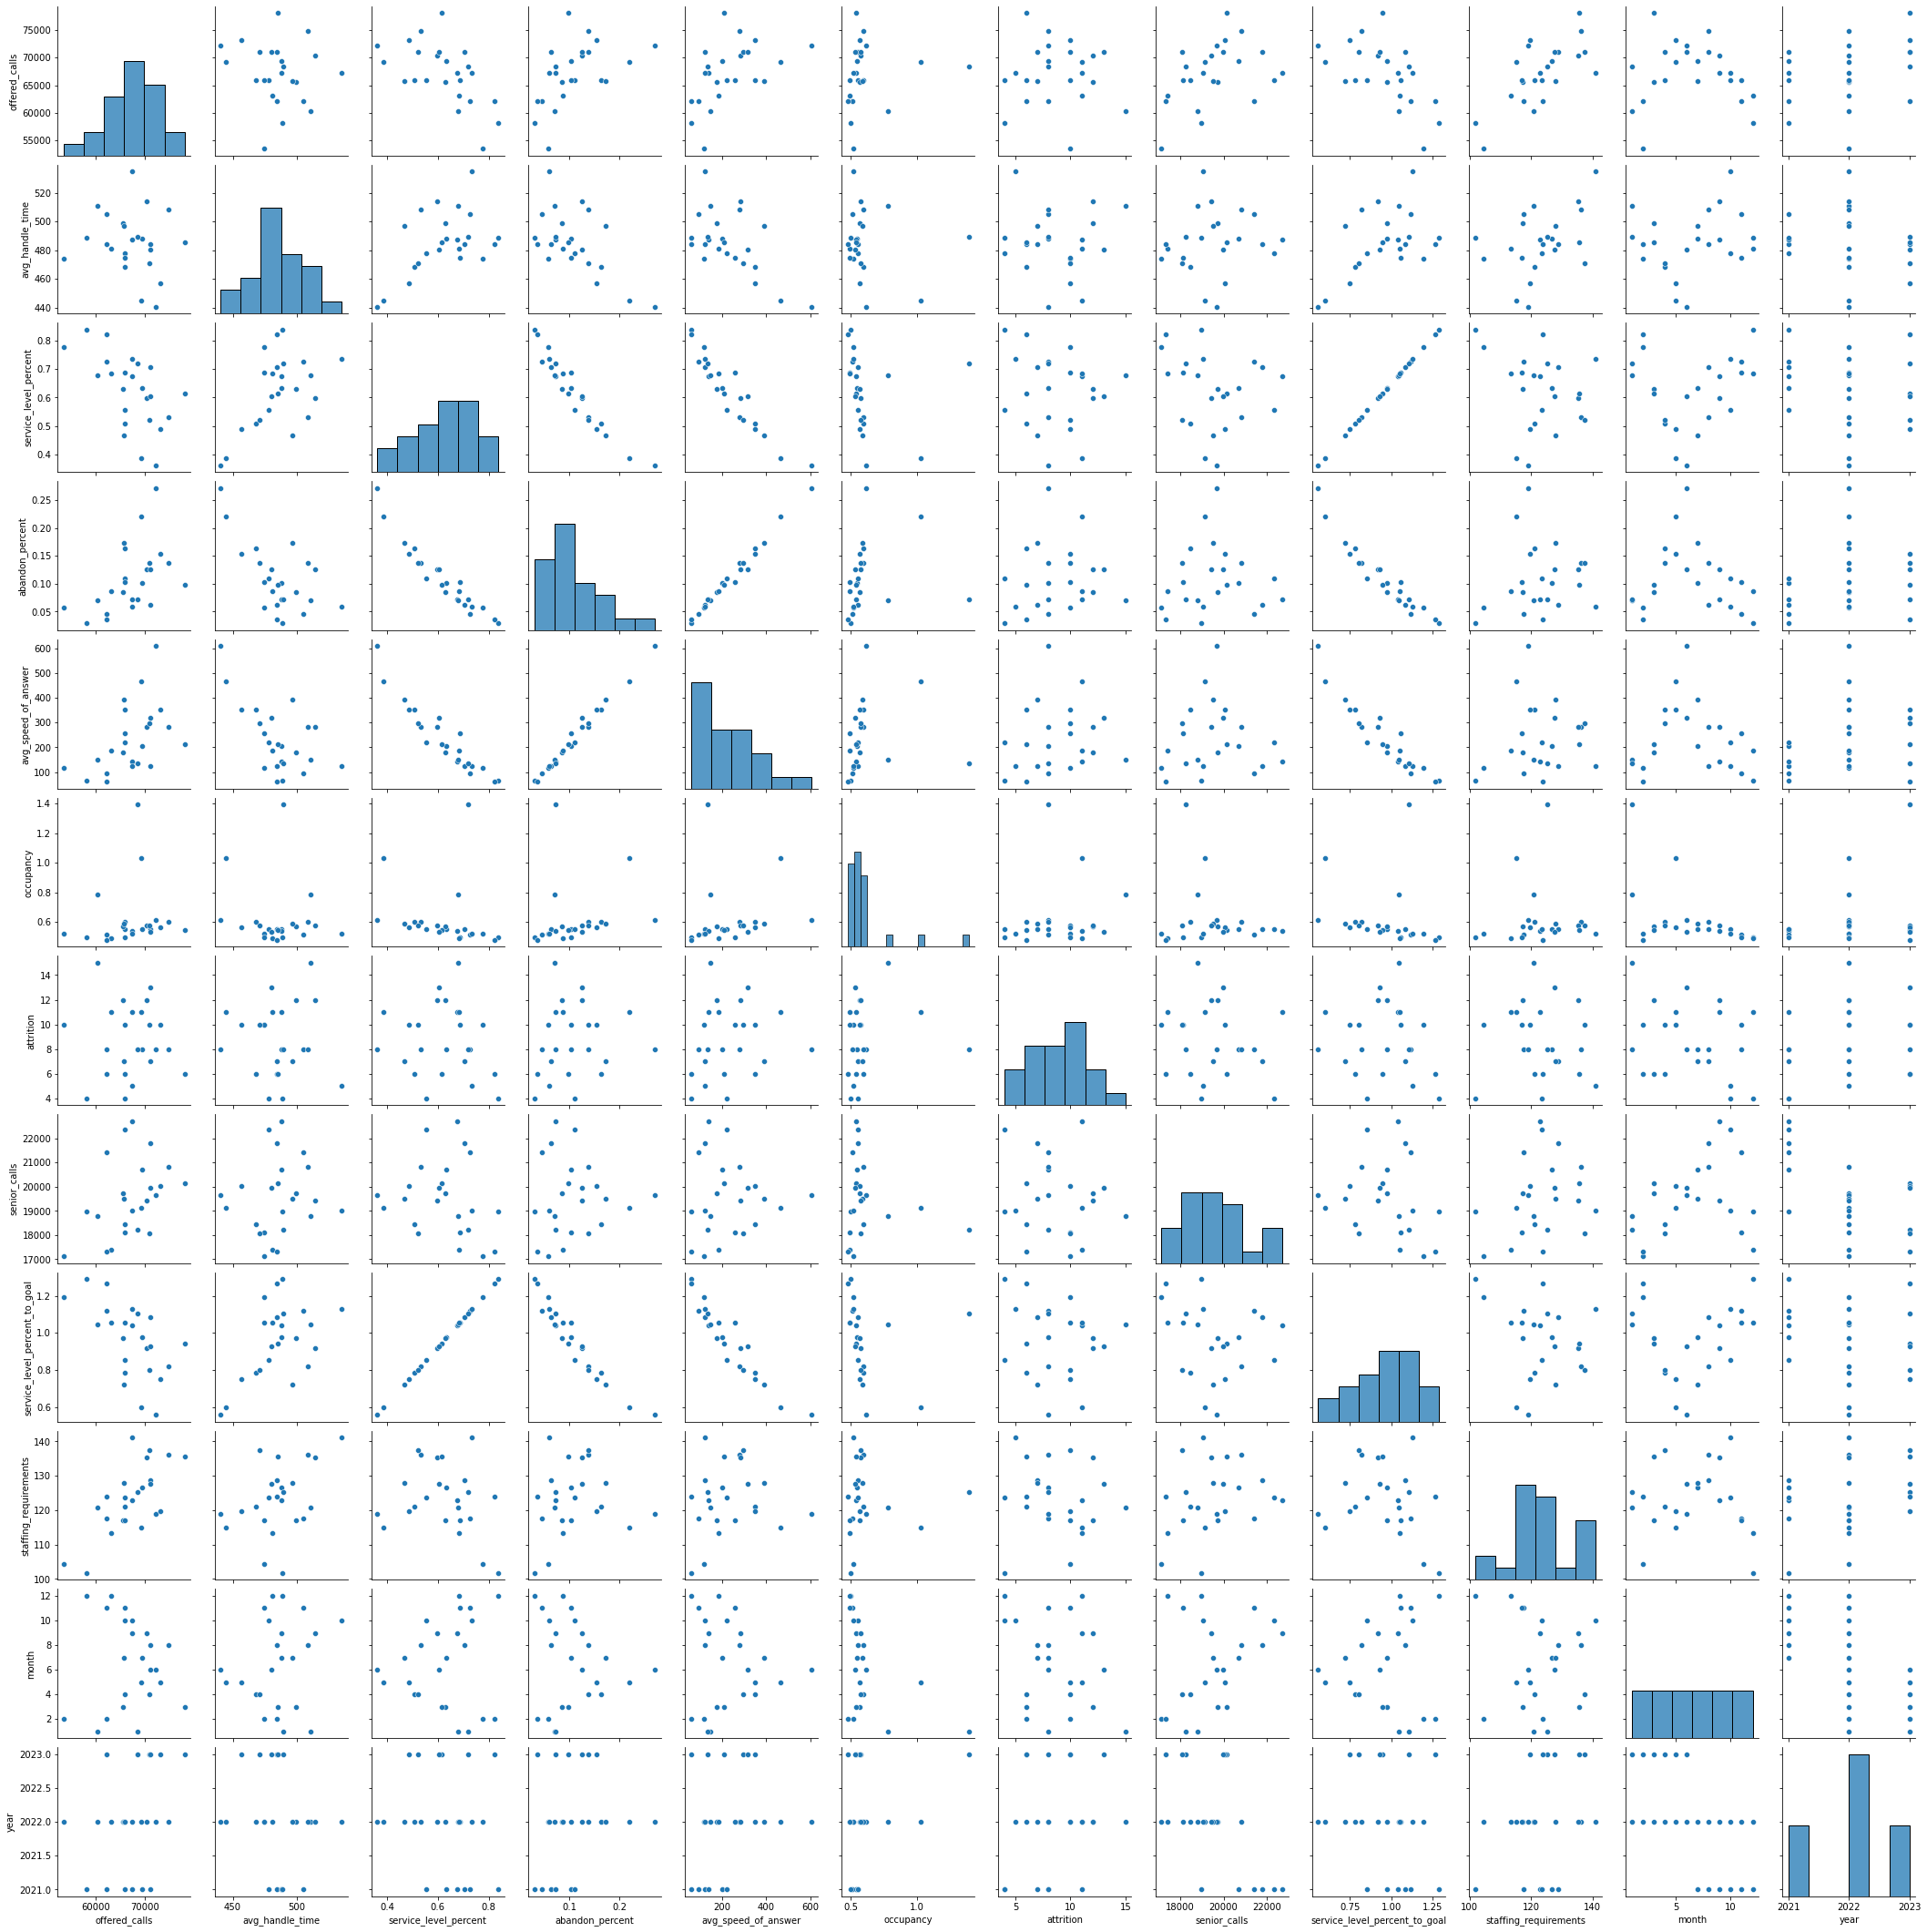

In [20]:
# Plot pairplot
sns.pairplot(df)
plt.show()

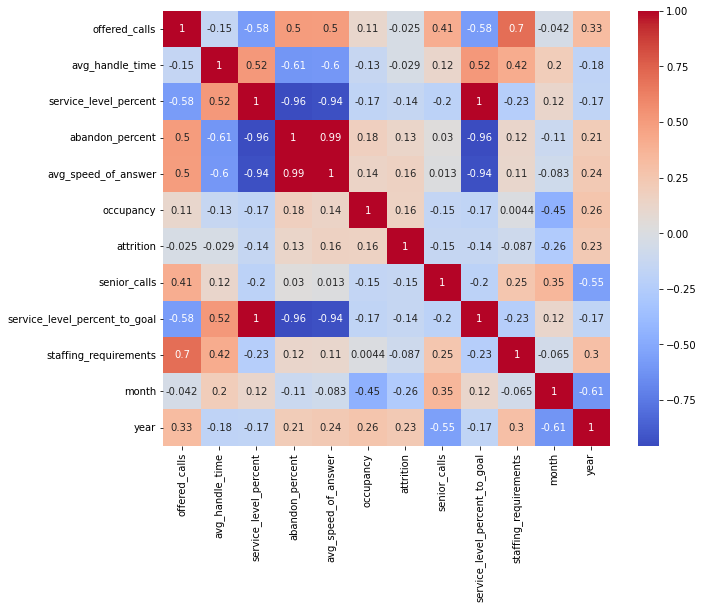

In [21]:
# Calculate correlations
correlations = df.corr()

# Display the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.show()

In [22]:
# Define the feature set X and the target y
X = df.drop(columns='staffing_requirements')
y = df['staffing_requirements']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19, 11), (5, 11), (19,), (5,))

In [23]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}') 
print(f'Mean Squared Error (MSE): {mse}')
print(f'R^2 Score: {r2}')

Mean Absolute Error (MAE): 5.02339447777504
Mean Squared Error (MSE): 45.33830452214212
R^2 Score: -1.61285923785529


In [24]:
# Get the coefficients of the linear regression model
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
print(coefficients)

                          Feature  Coefficient
0                   offered_calls     0.001078
1                 avg_handle_time     0.320501
2           service_level_percent    -8.155736
3                 abandon_percent   271.435156
4             avg_speed_of_answer    -0.125893
5                       occupancy   -16.911529
6                       attrition    -0.021028
7                    senior_calls    -0.000127
8   service_level_percent_to_goal   -12.547287
9                           month    -0.536209
10                           year     1.992195


In [25]:
# Instantiate the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = rf_model.predict(X_test)

In [26]:
# Calculate performance metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'Mean Absolute Error (MAE): {mae_rf}') 
print(f'Mean Squared Error (MSE): {mse_rf}')
print(f'R^2 Score: {r2_rf}')

Mean Absolute Error (MAE): 3.752211487046554
Mean Squared Error (MSE): 19.11674734839815
R^2 Score: -0.10170352494354251


In [27]:
# Get the feature importances from the Random Forest model
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
})

In [28]:
# Sort the features by their importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

                          Feature  Importance
0                   offered_calls    0.437057
1                 avg_handle_time    0.171171
9                           month    0.114819
7                    senior_calls    0.076271
6                       attrition    0.049230
5                       occupancy    0.042855
8   service_level_percent_to_goal    0.036275
2           service_level_percent    0.026817
4             avg_speed_of_answer    0.020522
3                 abandon_percent    0.014184
10                           year    0.010799


In [29]:
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate the Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)

# Fit the model to the training data
gb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_gb = gb_model.predict(X_test)

# Calculate performance metrics
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f'Mean Absolute Error (MAE): {mae_gb}') 
print(f'Mean Squared Error (MSE): {mse_gb}')
print(f'R^2 Score: {r2_gb}')

Mean Absolute Error (MAE): 7.5751213604689465
Mean Squared Error (MSE): 93.3038778365484
R^2 Score: -4.377128714945348


In [30]:
# Get the feature importances from the Gradient Boosting model
feature_importances_gb = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gb_model.feature_importances_
})

# Sort the features by their importance
feature_importances_gb = feature_importances_gb.sort_values(by='Importance', ascending=False)

print(feature_importances_gb)


                          Feature  Importance
0                   offered_calls    0.626802
1                 avg_handle_time    0.185678
4             avg_speed_of_answer    0.065146
7                    senior_calls    0.050879
10                           year    0.037855
9                           month    0.015346
6                       attrition    0.008294
3                 abandon_percent    0.003479
5                       occupancy    0.002648
2           service_level_percent    0.002173
8   service_level_percent_to_goal    0.001701
